# Titanic - Machine learning 

In this notebook, we try to find the best classifier to predict survived people after the titanic tragedy. 

## Import Python libraries



In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# visualization
import seaborn as sns # seaborn for visualization 
import matplotlib.pyplot as plt # matplotlib for visualization
%matplotlib inline

from sklearn.preprocessing import StandardScaler

# model
from sklearn.linear_model import LogisticRegression # Logistic Regression
from sklearn.ensemble import RandomForestClassifier # RandomForest Classifier
from sklearn.svm import SVC, LinearSVC # SVC
from sklearn.neighbors import KNeighborsClassifier # KNN
from sklearn.naive_bayes import GaussianNB # GaussianNB
from sklearn.linear_model import Perceptron # Perceptron
from sklearn.linear_model import SGDClassifier # SGD
from sklearn.tree import DecisionTreeClassifier # Tree Decision

# metrics
from sklearn.metrics import f1_score, accuracy_score

## Import data

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [3]:
# train data
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")

# test data
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")

# gender submission
gender_submission = pd.read_csv("/kaggle/input/titanic/gender_submission.csv")

In [4]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## Cleaning Data

### Train data

In [6]:
# Count missing value by column
missing_by_column = train_data.isnull().sum()

# Count missing value by row
missing_by_row = train_data.isnull().sum(axis=1)

In [7]:
# Due to an excessive missing value, we don't consider this feature in our study
train_data=train_data.drop('Cabin', axis=1)

### Test data

In [8]:
test_data['Fare'].fillna(test_data['Fare'].mean(), inplace=True)

/tmp/ipykernel_33/4063273702.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_data['Fare'].fillna(test_data['Fare'].mean(), inplace=True)


## Explore a pattern

Remember that the sample submission file in gender_submission.csv assumes that all female passengers survived (and all male passengers died).

Is this a reasonable first guess? We'll check if this pattern holds true in the data (in train.csv).

Copy the code below into a new code cell. Then, run the cell.

In [9]:
train_data[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


The data is not imbalance. It seeams, interesting to use F1-Score to assess model. 

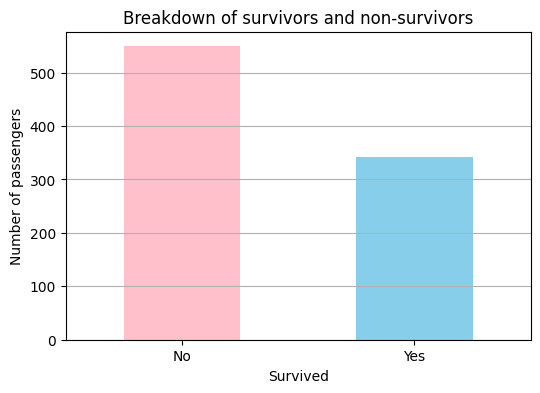

In [10]:
# Count the number of survived
survival_counts = train_data['Survived'].value_counts()

# Draw bar plot
plt.figure(figsize=(6, 4))
survival_counts.plot(kind='bar', color=['pink', 'skyblue'])
plt.title('Breakdown of survivors and non-survivors')
plt.xlabel('Survived')
plt.ylabel('Number of passengers')
plt.xticks([0, 1], ['No', 'Yes'], rotation=0)
plt.grid(axis='y')
plt.show()

There is a real imbalance between the survivor and non-survivor populations. The number of non-survivors is much higher than the number of survivors. 

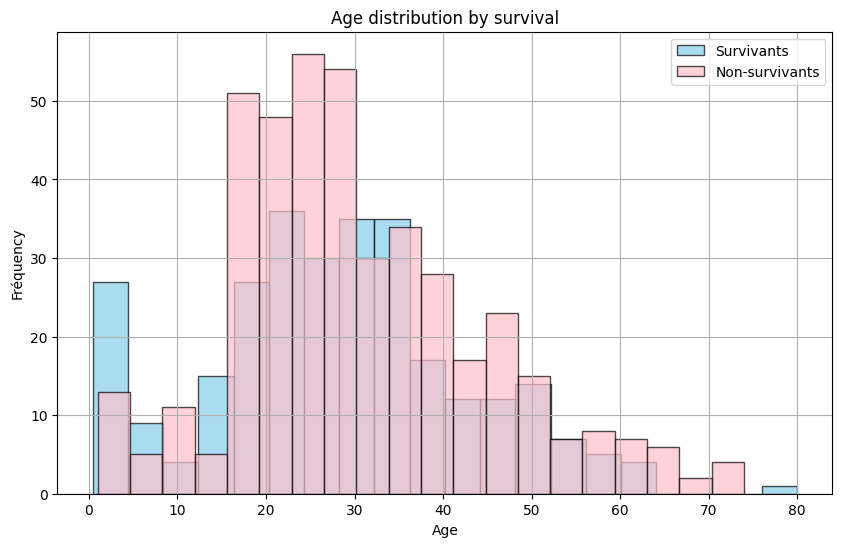

In [11]:
# Divided Dataframe in two dataframe
survived = train_data[train_data['Survived'] == 1]  # Survivants
not_survived = train_data[train_data['Survived'] == 0]  # Non-survivants

# Draw the histogram
plt.figure(figsize=(10, 6))

# Age distribution of survivors (in blue)
plt.hist(survived['Age'], bins=20, color='skyblue', edgecolor='black', alpha=0.7, label='Survivants')

# Age distribution of death (in pink)
plt.hist(not_survived['Age'], bins=20, color='pink', edgecolor='black', alpha=0.7, label='Non-survivants')

plt.xlabel('Age')
plt.ylabel('Fréquency')
plt.title('Age distribution by survival')
plt.legend()
plt.grid(True)
plt.show()

The distribution of deaths is disproportionate. 

In [12]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [13]:
train_data[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [14]:
train_data[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [15]:
train_data[["Parch", "Survived"]].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
/opt/conda/lib/python3.10/site-pack

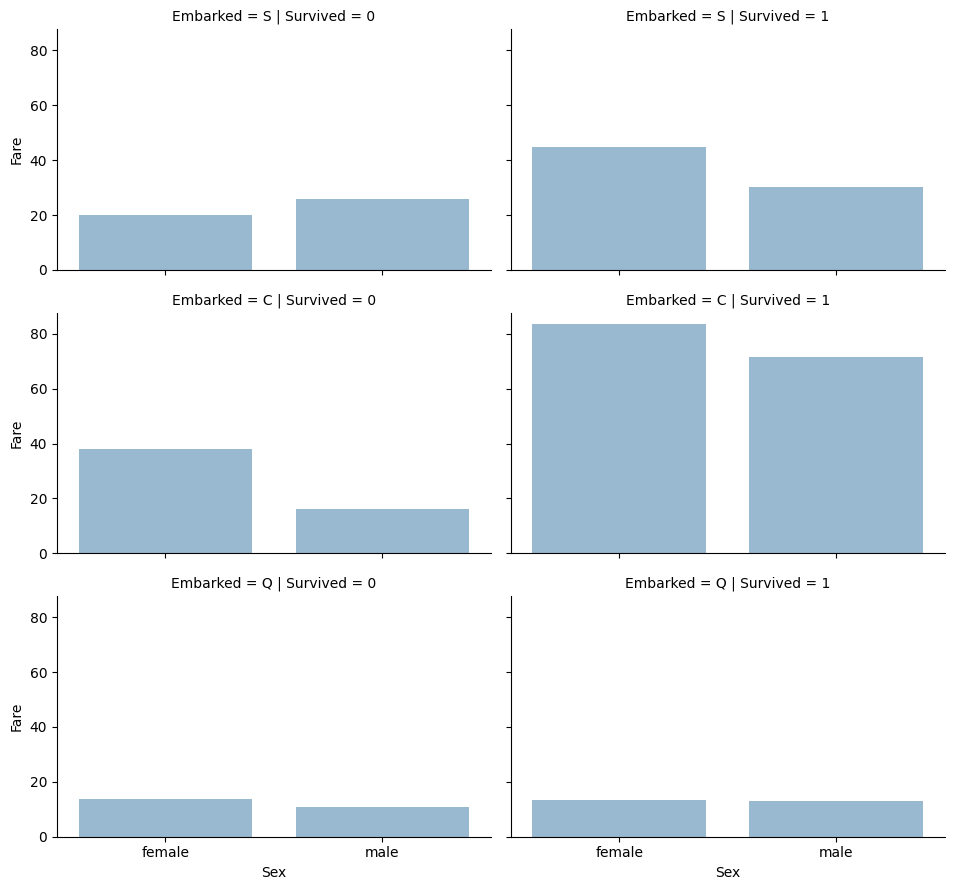

In [16]:
# grid = sns.FacetGrid(train_df, col='Embarked', hue='Survived', palette={0: 'k', 1: 'w'})
grid = sns.FacetGrid(train_data, row='Embarked', col='Survived', aspect=1.6)
grid.map(sns.barplot, 'Sex', 'Fare', alpha=.5, ci=None)
grid.add_legend()

## Relationship between features

We observe the correlation between target and each features. 

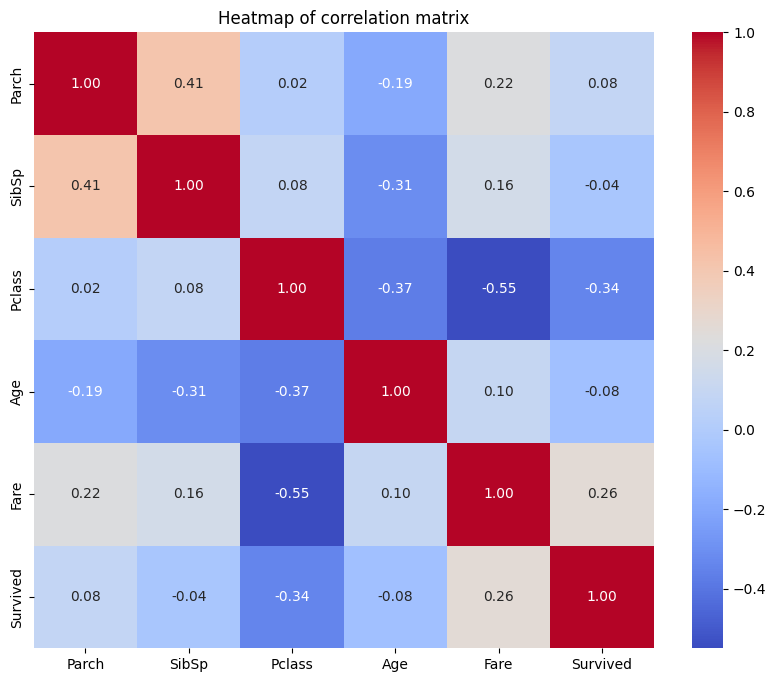

In [17]:
# Compute correlation matrix
correlation_matrix = train_data[["Parch", "SibSp", "Pclass", "Age", "Fare", "Survived"]].corr()

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap of correlation matrix')
plt.show()

In [18]:
y = train_data["Survived"] # the target

features = ["Parch", "SibSp", "Pclass", "Fare", "Embarked"] # features
X = pd.get_dummies(train_data[features])
X_test = pd.get_dummies(test_data[features])

We observe that every features are not correlate. It is interesting in our study to take all feature. 

## Random Forest Model

We'll build what's known as a **random forest model**. This model is constructed of several "trees" (there are three trees in the picture below, but we'll construct 100!) that will individually consider each passenger's data and vote on whether the individual survived. Then, the random forest model makes a democratic decision: the outcome with the most votes wins!

In [19]:
model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
model.fit(X, y)
predictions = model.predict(X_test)

output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})

In [20]:
acc_random_forest = f1_score(gender_submission["Survived"], output["Survived"])

In [21]:
print(accuracy_score(gender_submission["Survived"], output["Survived"]))

0.6698564593301436


## Logistic Regression Model

We'll build what's known as a **logistic regression model**. Logistic Regression is a useful model to run early in the workflow. Logistic regression measures the relationship between the categorical dependent variable (feature) and one or more independent variables (features) by estimating probabilities using a logistic function, which is the cumulative logistic distribution.


In [22]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.fit_transform(X_test)

In [24]:
logreg = LogisticRegression()
logreg.fit(X, y)
Y_pred_logreg = logreg.predict(X_test)

output_logreg = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': Y_pred_logreg})

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [25]:
acc_log = f1_score(gender_submission["Survived"], output_logreg["Survived"])

In [26]:
print(accuracy_score(gender_submission["Survived"], output_logreg["Survived"]))

0.6172248803827751


## Support Vector Machine

We'll build what's known as a **support vector machine**. They are supervised learning models with associated learning algorithms that analyze data used for classification and regression analysis. Given a set of training samples, each marked as belonging to one or the other of two categories, an SVM training algorithm builds a model that assigns new test samples to one category or the other, making it a non-probabilistic binary linear classifier.

In [28]:
svc = SVC()
svc.fit(X_scaled, y)
Y_pred_svc = svc.predict(X_test_scaled)

output_svc = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': Y_pred_svc})

In [29]:
acc_svc = f1_score(gender_submission["Survived"], output_svc["Survived"])

In [30]:
print(accuracy_score(gender_submission["Survived"], output_svc["Survived"]))

0.6770334928229665


## Gaussian Naive Bayes

We'll build what's known as a **Gaussian Naive Bayes**. In machine learning, naive Bayes classifiers are a family of simple probabilistic classifiers based on applying Bayes' theorem with strong (naive) independence assumptions between the features. Naive Bayes classifiers are highly scalable, requiring a number of parameters linear in the number of variables (features) in a learning problem

In [31]:
gaussian = GaussianNB()
gaussian.fit(X_scaled, y)
Y_pred_gaussian = gaussian.predict(X_test_scaled)

output_gaussian = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': Y_pred_gaussian})

In [32]:
acc_gaussian = f1_score(gender_submission["Survived"], output_gaussian["Survived"])

In [33]:
print(accuracy_score(gender_submission["Survived"], output_gaussian["Survived"]))

0.6028708133971292


## Perceptron

We'll build what's known as a **Perceptron**. The perceptron is an algorithm for supervised learning of binary classifiers (functions that can decide whether an input, represented by a vector of numbers, belongs to some specific class or not).


In [40]:
perceptron = Perceptron()
perceptron.fit(X_scaled, y)
Y_pred_perceptron = perceptron.predict(X_test_scaled)

output_perceptron = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': Y_pred_perceptron})

In [41]:
acc_perceptron = f1_score(gender_submission["Survived"], output_perceptron["Survived"])

In [42]:
print(accuracy_score(gender_submission["Survived"], output_perceptron["Survived"]))

0.5239234449760766


## Conclusion

In [43]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron' 
              ],
    'Score': [acc_svc, acc_log, 
              acc_random_forest, acc_gaussian, acc_perceptron]})
models.sort_values(by='Score', ascending=False)

,Model,Score
0,Support Vector Machines,0.509091
4,Perceptron,0.508642
2,Random Forest,0.477273
1,Logistic Regression,0.420290
3,Naive Bayes,0.380597


In [44]:
output_svc.to_csv('submission2.csv', index=False)